## Tutorial VI.1

Consider a long-term multi-year investment problem where **CSP (Concentrated Solar Power)** has a learning curve such that

$$LCOE = c_0 \left(\frac{x_t}{x_0}\right)^{-\gamma} + c_1$$

where $c_0$ is cost at start, $c_1$ is material cost and $x_t$ is cumulative
capacity in the investment interval $t$. Thus, $x_0$ is the initial cumulative CSP capacity.

Additionally, there are **nuclear** and **coal** generators for which there is no potential for reducing their LCOE.

We build an optimisation to minimise the cost of supplying a flat demand $d=100$ with the given technologies between 2020 and 2050, where a CO$_2$ budget cap is applied.

> **Hint:** Problem formulation is to be found further along this notebook.

**Task:** Explore different discount rates, learning rates, CO$_2$ budgets. For instance
* No learning for CSP and no CO$_2$ budget would result in a coal-reliant system.
* A CO$_2$ budget and no learning prefers a system built on nuclear.
* A CO$_2$ budget and learning results in a system with CSP.

***
## Imports

In [1]:
from pyomo.environ import ConcreteModel, Var, Objective, NonNegativeReals, Constraint, Suffix, exp
from pyomo.opt import SolverFactory
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

## Parameters

In [2]:
techs = ["coal","nuclear","CSP"]
colors = ["#707070","#ff9000","#f9d002"]
parameters = pd.DataFrame(data=[[50.,100.,150.,"LCOE EUR/MWh_el"],
                                [1.,0.,0., "tCO2/MWh_el"],
                                [50.,100.,35., "EUR/MWh_el"],
                                [1e6,1e6,200,"GW"]],
                          index=["current LCOE","specific emissions","potential LCOE","current volume"],
                          columns=techs+["unit"])
parameters

coal    nuclear    CSP             unit
current LCOE             50.0      100.0  150.0  LCOE EUR/MWh_el
specific emissions        1.0        0.0    0.0      tCO2/MWh_el
potential LCOE           50.0      100.0   35.0       EUR/MWh_el
current volume      1000000.0  1000000.0  200.0               GW

In [82]:
#discount rate
rate = 0.05

#demand in GW
demand = 100.

#learning rate of CSP
gamma_csp = 0.333

# carbon budget in average tCO2/MWh_el
co2_budget = 0.2

# considered years
years = list(range(2020,2050))

## Build Model
> **Note:** We use [`pyomo`](https://pyomo.readthedocs.io/en/stable/) for building optimisation problems in python. This is also what `pypsa` uses under the hood.

In [99]:
model = ConcreteModel("discounted total costs")

$$G_{t,a}$$

In [100]:
model.generators = Var(techs, years, within=NonNegativeReals)

$$LCOE_{t,a}$$

In [101]:
model.costs = Var(techs, years, within=NonNegativeReals)

The objective is to minimise the system costs:

$$\min \quad \sum_{t\in T, a\in A} G_{t,a}\cdot LCOE_{t,a} \cdot \frac{8760}{10^6\cdot (1+r)^{t}}$$

In [102]:
# in billion EUR
model.objective = Objective(expr=sum(model.generators[tech,year]*model.costs[tech,year]*8760/1e6/(1+rate)**(year-years[0])
                                     for year in years
                                     for tech in techs))

Add a constraint such that demand is met by generator dispatch:

$$\forall a\in A: \quad d = \sum_{t \in T} G_{t,a}$$

In [103]:
def balance_constraint(model, year):
    return demand == sum(model.generators[tech,year] for tech in techs)
model.balance_constraint = Constraint(years, rule=balance_constraint)

Add a constraint on carbon dioxide emissions:

$$\sum_{t\in T, a\in A} G_{t,a} \cdot e_{t} \leq \hat{e} \cdot |A| \cdot d$$

In [104]:
def co2_constraint(model):
    return co2_budget*len(years)*demand >= sum(model.generators[tech,year]*parameters.at["specific emissions",tech] for tech in techs for year in years)
model.co2_constraint = Constraint(rule=co2_constraint)

In [105]:
def lcoe_constraint(model,tech,year):
    if tech != "CSP":
        return model.costs[tech,year] == parameters.at["current LCOE",tech]
    else:
        return model.costs[tech,year] == parameters.at["potential LCOE",tech] + (parameters.at["current LCOE",tech]-parameters.at["potential LCOE",tech])*(1+sum(model.generators[tech,yeart] for yeart in years if yeart < year))**(-gamma_csp)
model.lcoe_constraint = Constraint(techs, years, rule=lcoe_constraint)

> **Hint:** You can print the model formulation with `model.pprint()`

## Solve Model

In [106]:
opt = SolverFactory("ipopt")

In [107]:
results = opt.solve(model,suffixes=["dual"],keepfiles=False)

## Results

Optimised cost (in billion euros NPV):

In [108]:
print(model.objective())

708.558421920427


The unoptimized cost (where everything is supplied by coal) is:

In [109]:
print(8760*demand*parameters.at["current LCOE","coal"]*len(years)/1e6)

1314.0


Plotting the development of the technology mix of the optimal solution over time:

In [110]:
capacities = pd.DataFrame(0.,index=years,columns=techs)
for year in years:
    for tech in techs:
        capacities.at[year,tech] = model.generators[tech,year].value

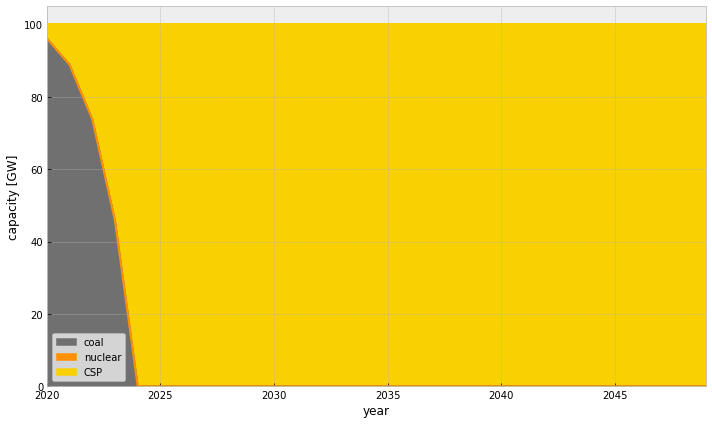

In [111]:
fig, ax = plt.subplots()

fig.set_size_inches((10,6))

capacities.plot(kind="area",stacked=True,color=colors,ax=ax)
ax.set_xlabel("year")
ax.set_ylabel("capacity [GW]")

fig.tight_layout()

fig.savefig("co2-0p2-learning.pdf",transparent=True)

Plotting the development of the costs of the technology over time:

In [112]:
costs = pd.DataFrame(0.,index=years,columns=techs)
for year in years:
    for tech in techs:
        costs.at[year,tech] = model.costs[tech,year].value

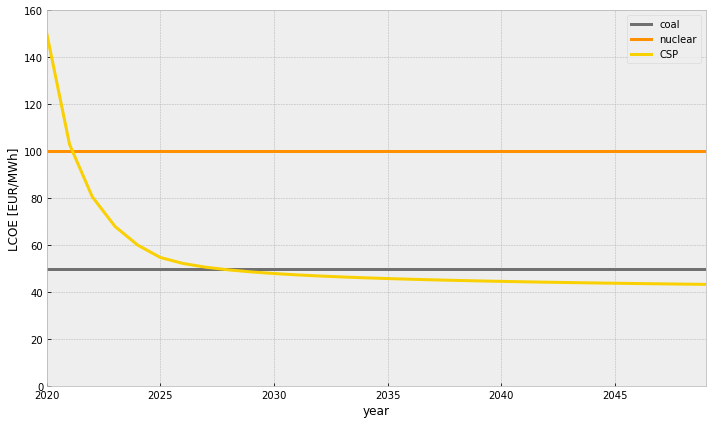

In [113]:
fig, ax = plt.subplots()

fig.set_size_inches((10,6))

costs.plot(color=colors,ax=ax,linewidth=3)
ax.set_xlabel("year")
ax.set_ylabel("LCOE [EUR/MWh]")
ax.set_ylim([0,160])


fig.tight_layout()

fig.savefig("lcoe-learning.pdf",transparent=True)